## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

import os

In [ ]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 32
epochs = 25

## Get data

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In TensorFlow this can be done via the `tf.keras.preprocessing.image.ImageDataGenerator` class. This class allows you to:

- configure random transformations and normalization operations to be done on your image data during training
- instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the `tf.keras` model methods that accept data generators as inputs, `fit`, `evaluate` and `predict`.

In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Datasets"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")

# Identify Plant Diseases

We use the PlantVillage dataset [1] by Hughes et al. consists of about 87,000 healthy and unhealthy leaf images divided into 38 categories by species and disease. Here we provide a subset of our experiments on working with this data. We also end up transfer learning from MobileNet and use the weights from pre-training on ImageNet.

* ![PlantVillage Dataset Samples](https://i.imgur.com/Zcxdrlc.png)
Figure 1. PlantVillage Dataset Samples

## Classes

The following 38 classes are availaible in the dataset

- `Apple___Apple_scab`
- `Apple___Black_rot`
- `Apple___Cedar_apple_rust`
- `Apple___healthy`
- `Blueberry___healthy`
- `Cherry_(including_sour)___Powdery_mildew`
- `Cherry_(including_sour)___healthy`
- `Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot`
- `Corn_(maize)___Common_rust_`
- `Corn_(maize)___Northern_Leaf_Blight`
- `Corn_(maize)___healthy', 'Grape___Black_rot`
- `Grape___Leaf_blight_(Isariopsis_Leaf_Spot)`
- `Grape___healthy`
- `Orange___Haunglongbing_(Citrus_greening)`
- `Peach___Bacterial_spot`
- `Peach___healthy`
- `Pepper,_bell___Bacterial_spot`
- `Pepper,_bell___healthy`
- `Potato___Early_blight`
- `Potato___Late_blight`
- `Potato___healthy`
- `Raspberry___healthy`
- `Soybean___healthy`
- `Squash___Powdery_mildew`
- `Strawberry___Leaf_scorch`
- `Strawberry___healthy`
- `Tomato___Bacterial_spot`
- `Tomato___Late_blight`
- `Tomato___Leaf_Mold`
- `Tomato___Septoria_leaf_spot`
- `Tomato___Spider_mites Two-spotted_spider_mite`
- `Tomato___Target_Spot`
- `Tomato___Tomato_Yellow_Leaf_Curl_Virus`
- `Tomato___Tomato_mosaic_virus`
- `Tomato___healthy`

## References

[1] Hughes, David P., and Marcel Salathe. “An Open Access Repository of Images on Plant Health to Enable the Development of Mobile Disease Diagnostics.” ArXiv:1511.08060 [Cs], Apr. 2016. arXiv.org, http://arxiv.org/abs/1511.08060.

[2] Howard, Andrew G., et al. “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.” ArXiv:1704.04861 [Cs], Apr. 2017. arXiv.org, http://arxiv.org/abs/1704.04861.


We make the following augmentations to the images:

- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- `rescale` is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- `shear_range` is for randomly applying shearing transformations
- `zoom_range` is for randomly zooming inside pictures
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

Let's prepare our data. We will use `.flow_from_directory()` to generate batches of image data (and their labels) directly from our images in their respective folders.

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = batch_size,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             class_mode = "categorical")

Found 43420 images belonging to 38 classes.
Found 17600 images belonging to 38 classes.


## Create a classes index file

We also want to know which class corresponds to which species and disease so we also create a `json` file which shows corresponding labels and class indices.

In [ ]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [ ]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/content/class_indices.json

## Training

We first get the base MobileNet model without including the top layers since we want to use it for 38 classes and us the pre-trained weights for ImageNet.

In [ ]:
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We now create a small upstream model on top of the MobileNet using the functional API

In [ ]:
inputs = keras.Input(shape = input_shape)

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories),
                          activation="softmax")(x)

model = keras.Model(inputs = inputs,
                    outputs = x,
                    name="LeafDisease_MobileNet")

In our multiple experiments we found out Adam optimizer to work really well with it's default learning rate, $\beta_1$, $\beta_2$ and $\epsilon$ values

In [ ]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(),
                       'accuracy'])

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


150/150 ━━━━━━━━━━━━━━━━━━━━ 2384s 16s/step - accuracy: 0.3102 - categorical_accuracy: 0.3102 - loss: 2.5198 - val_accuracy: 0.4897 - val_categorical_accuracy: 0.4897 - val_loss: 4.2850
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1926s 13s/step - accuracy: 0.7713 - categorical_accuracy: 0.7713 - loss: 0.7912 - val_accuracy: 0.5406 - val_categorical_accuracy: 0.5406 - val_loss: 4.2987
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1616s 11s/step - accuracy: 0.8184 - categorical_accuracy: 0.8184 - loss: 0.5975 - val_accuracy: 0.5747 - val_categorical_accuracy: 0.5747 - val_loss: 4.2067
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1390s 9s/step - accuracy: 0.8466 - categorical_accuracy: 0.8466 - loss: 0.4829 - val_accuracy: 0.5484 - val_categorical_accuracy: 0.5484 - val_loss: 4.4716
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1269s 9s/step - accuracy: 0.8818 - categorical_accuracy: 0.8818 - loss: 0.3993 - val_accuracy: 0.5756 - val_categorical_accuracy: 0.5756 - val_loss: 4.3879
Epoch 6/25
150/150 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9113 - categorical_accuracy: 0.9113 - loss: 0.3048 - val_accuracy: 0.5856 - val_categorical_accuracy: 0.5856 - val_loss: 4.6905
Epoch 11/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 781s 5s/step - accuracy: 0.8964 - categorical_accuracy: 0.8964 - loss: 0.3203 - val_accuracy: 0.5972 - val_categorical_accuracy: 0.5972 - val_loss: 4.6713
Epoch 12/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 742s 5s/step - accuracy: 0.8888 - categorical_accuracy: 0.8888 - loss: 0.3207 - val_accuracy: 0.5809 - val_categorical_accuracy: 0.5809 - val_loss: 4.8041
Epoch 13/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 678s 5s/step - accuracy: 0.9060 - categorical_accuracy: 0.9060 - loss: 0.2884 - val_accuracy: 0.5831 - val_categorical_accuracy: 0.5831 - val_loss: 4.8831
Epoch 14/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 624s 4s/step - accuracy: 0.9094 - categorical_accuracy: 0.9094 - loss: 0.2695 - val_accuracy: 0.5934 - val_categorical_accuracy: 0.5934 - val_loss: 4.9867
Epoch 15/25
150/150 ━━━━━━━━━━━━

## Review the training process

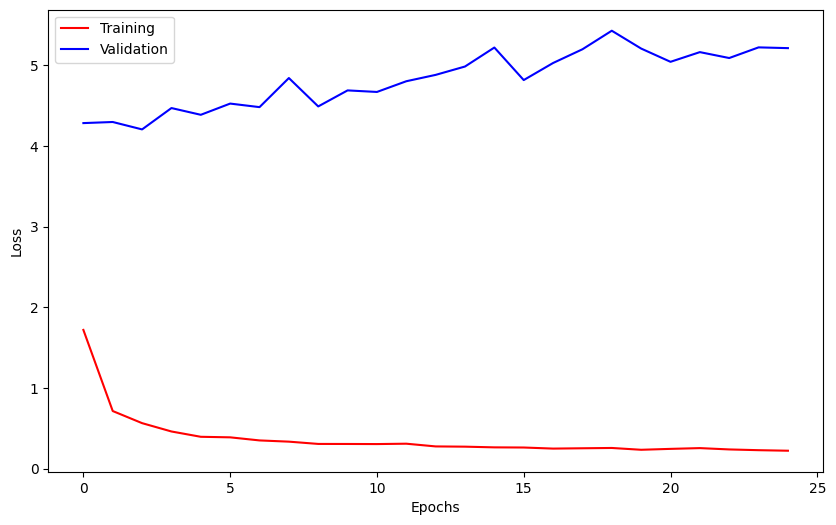

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

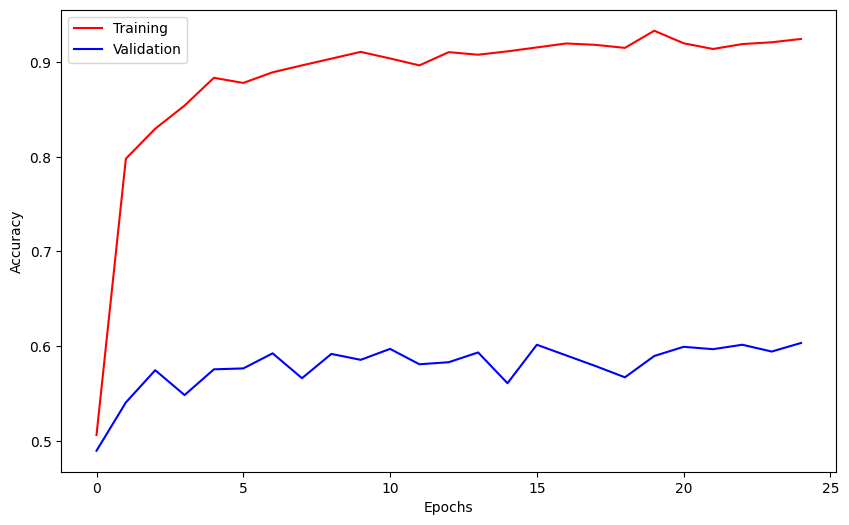

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Save the model
We finally save the model in the standard TensorFlow 2 SavedModel format.

In [ ]:
model.save('plant_disease.keras')  # Recommended

In [ ]:
from google.colab import files
files.download('plant_disease.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>